In [60]:
# Dependencies and Setup
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

In [87]:
# Name of the CSV file
file = 'Historical Interest Rate Data/Historical Interest Rate Data - 1990 - 2022.xlsx'

ir_df = pd.read_excel(file, sheet_name ='Sheet1', index_col=0, dtype={'Effective Date':'datetime64[ns]', 'Cash Rate Target': float})

peaks_date = ["1994-07-27","1999-10-05","2006-04-04","2007-07-03","2009-09-02"]
timepoint = [0,30,60,90,120,150,180]

date_lst = []
timepoint_lst = []
nopeaks_lst = []
peaks_lst = []

# counter
i = 1

for dt in peaks_date:
    startdate = datetime.strptime(dt, '%Y-%m-%d')
    for t in range(len(timepoint)):
        if timepoint[t] == 0:
            enddate = startdate 
        else: enddate = startdate + timedelta(days=timepoint[t])
        #Make sure dates doesn't land on Weekends
        if enddate.weekday() > 4:
            print(enddate)
            if enddate.weekday() == 5:
                enddate = enddate + timedelta(days=3)
            else: enddate = enddate + timedelta(days=2)
        
        peaks_lst.append(enddate)
        timepoint_lst.append(timepoint[t])
        nopeaks_lst.append(i)
        t += 1
    i += 1

# Dataframe of dates of interest and it's corresponding peaks
peaks_df = pd.DataFrame({'Peak':nopeaks_lst,'Timepoint': timepoint_lst,'Date': peaks_lst})
peaks_df.head(7)


1994-09-25 00:00:00
1994-12-24 00:00:00
1999-12-04 00:00:00
2000-04-02 00:00:00
2006-06-03 00:00:00
2006-10-01 00:00:00
2007-09-01 00:00:00
2007-12-30 00:00:00
2009-11-01 00:00:00
2010-01-30 00:00:00


,Peak,Timepoint,Date
0,1,0,1994-07-27
1,1,30,1994-08-26
2,1,60,1994-09-27
3,1,90,1994-10-25
4,1,120,1994-11-24
5,1,150,1994-12-27
6,1,180,1995-01-23


In [88]:
# Using Pandas grouping to group the data by Peaks
peaks_grouped = peaks_df.groupby('Peak')
# Get series of the first value of the group index
startdt_lst = peaks_grouped['Date'].first()
# Get series of the Last value of the group index
enddt_lst =  peaks_grouped['Date'].last()

In [89]:
# Create a function to make a mask
def Inbetween_(start_date, end_date):
    mask = (ir_df.index > start_date) & (ir_df.index <= end_date)
    return mask 

# Data Splice to different group
Peak_1 = ir_df[Inbetween_(startdt_lst.values[0],enddt_lst.values[0])]
Peak_2 = ir_df[Inbetween_(startdt_lst.values[1],enddt_lst.values[1])]
Peak_3 = ir_df[Inbetween_(startdt_lst.values[2],enddt_lst.values[2])]
Peak_4 = ir_df[Inbetween_(startdt_lst.values[3],enddt_lst.values[3])]
Peak_5 = ir_df[Inbetween_(startdt_lst.values[4],enddt_lst.values[4])]


In [90]:
#GETTING ASX STOCK DATA
# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1991-01-01'
end_date = '2021-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader('^AXJO', 'yahoo', start_date, end_date)

# Create a function to make a mask
def Inbetween_(start_date, end_date,df):
    mask = (df.index > start_date) & (df.index <= end_date)
    return mask 

# Data Splice to different group
Stock_Peak_1 = panel_data[Inbetween_(startdt_lst.values[0],enddt_lst.values[0],panel_data)]
Stock_Peak_2 = panel_data[Inbetween_(startdt_lst.values[1],enddt_lst.values[1],panel_data)]
Stock_Peak_3 = panel_data[Inbetween_(startdt_lst.values[2],enddt_lst.values[2],panel_data)]
Stock_Peak_4 = panel_data[Inbetween_(startdt_lst.values[3],enddt_lst.values[3],panel_data)]
Stock_Peak_5 = panel_data[Inbetween_(startdt_lst.values[4],enddt_lst.values[4],panel_data)]

# Save plot 
panel_data.to_csv('panel_data.csv')

# Put everything in the list for easy access
IR_peak_lst = [Peak_1,Peak_2,Peak_3,Peak_4,Peak_5]
ASX_peak_lst = [Stock_Peak_1,Stock_Peak_2,Stock_Peak_3,Stock_Peak_4,Stock_Peak_5]

In [97]:
ASXpeaks_df = peaks_df

close_price = []
i = 0
j = 1

for dt_ in ASXpeaks_df['Date']: 
    #print(dt_)
    try: 
        price_ = panel_data['Close'][panel_data.index == dt_].values[0]
    except:
        price_ = 0
        if price_ == 0: 
            for j in range(7):
                try:
                    price_ = panel_data['Close'][panel_data.index == (dt_ + timedelta(days=j))].values[0]
                    print(dt_ + timedelta(days=j))
                except:
                    price_ = 0
                
                if price_ != 0:
                    price_ = price_
                    break
            j += 1
    
    #print(price_)
    close_price.append(price_)

#print(len(ASXpeaks_df['Date']), len(close_price))

ASXpeaks_df['ASX'] = close_price

ASXpeaks_df

#a = panel_data['Close'][panel_data.index == '1992-11-22']
#a.values[0]

#panel_data['Close'][panel_data.index == ASXpeaks_df['Date'][0]].values[0]

2000-03-05 00:00:00
2007-12-02 00:00:00
2010-01-03 00:00:00


,Peak,Timepoint,Date,ASX
0,1,0,1994-07-27,1982.199951
1,1,30,1994-08-26,2021.599976
2,1,60,1994-09-27,1952.300049
3,1,90,1994-10-25,1956.599976
4,1,120,1994-11-24,1854.199951
5,1,150,1994-12-27,1884.000000
6,1,180,1995-01-23,1813.400024
7,2,0,1999-10-05,2854.600098
8,2,30,1999-11-04,2864.600098
9,2,60,1999-12-07,3053.000000


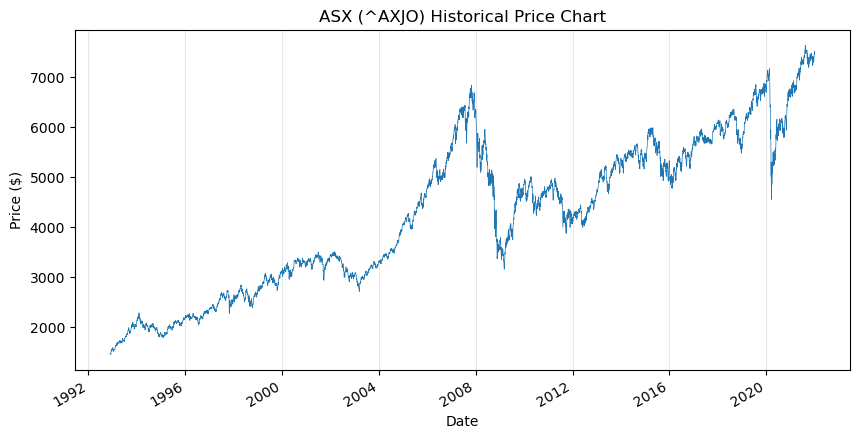

In [66]:
# Plot ASX Data
ax = panel_data['Close'].plot(figsize=(10, 5), use_index=True, ylabel='Price ($)',lw=0.5)
ax.set_title('ASX (^AXJO) Historical Price Chart')
ax.grid(axis='x', alpha=0.3)
fig = ax.get_figure()
fig.savefig("ASX CHART")

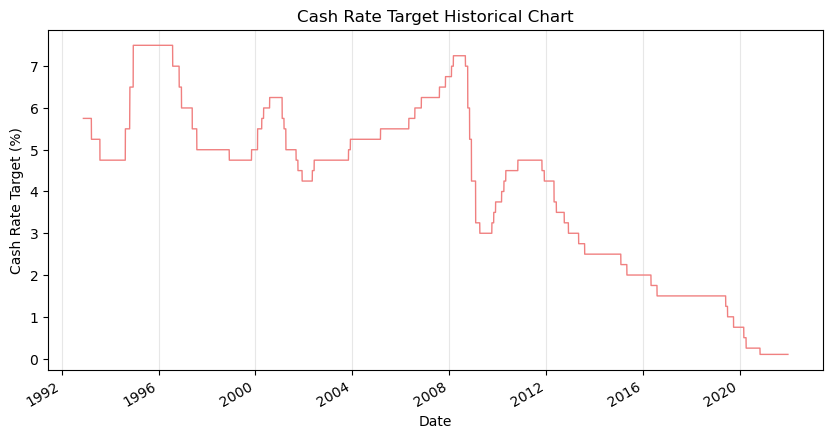

In [67]:
# Plot Interest Rate Data
ax = ir_df.plot(label='Cash',color = 'lightcoral', lw=1)
ax.set_title('Cash Rate Target Historical Chart')
ax.set_ylabel('Cash Rate Target (%)')
ax.set_xlabel('Date')
ax.get_legend().remove()
ax.grid(axis='x', alpha=0.3)
fig = ax.get_figure()
fig.set_size_inches(10,5)
fig.savefig("IR CHART")

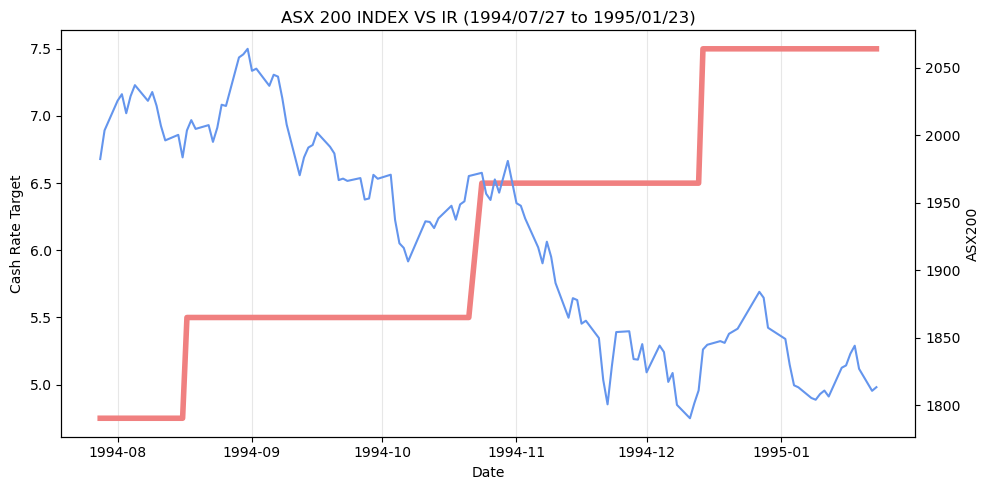

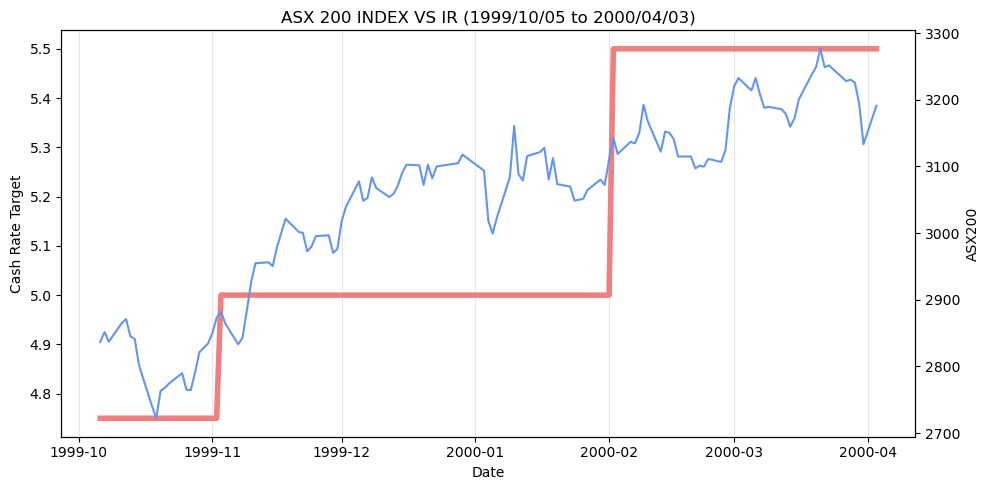

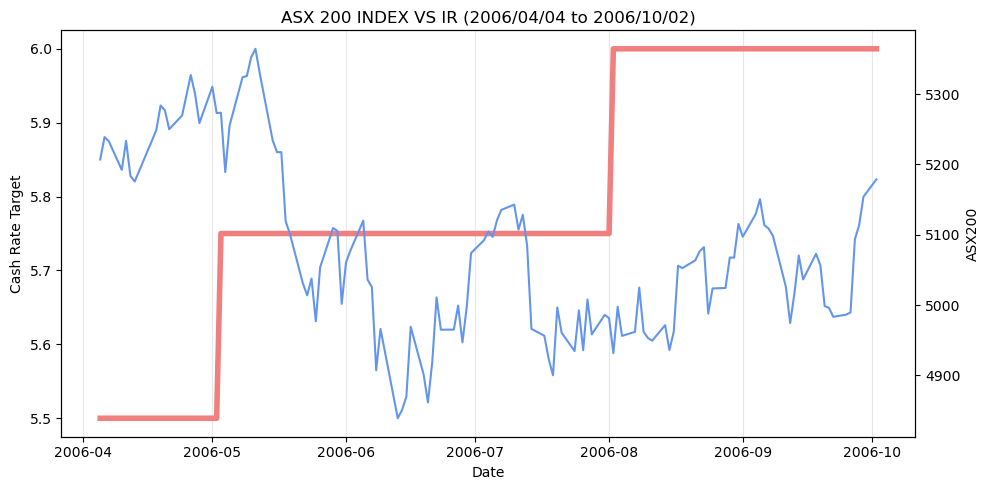

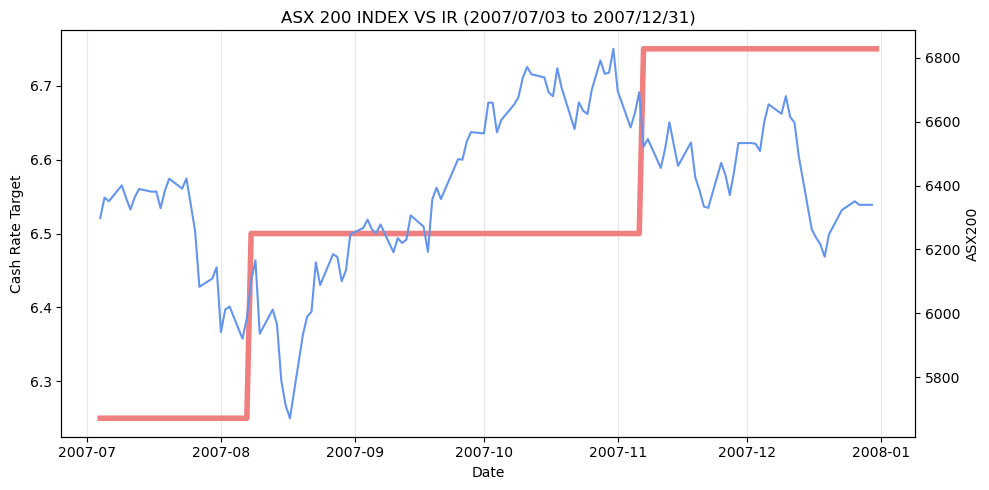

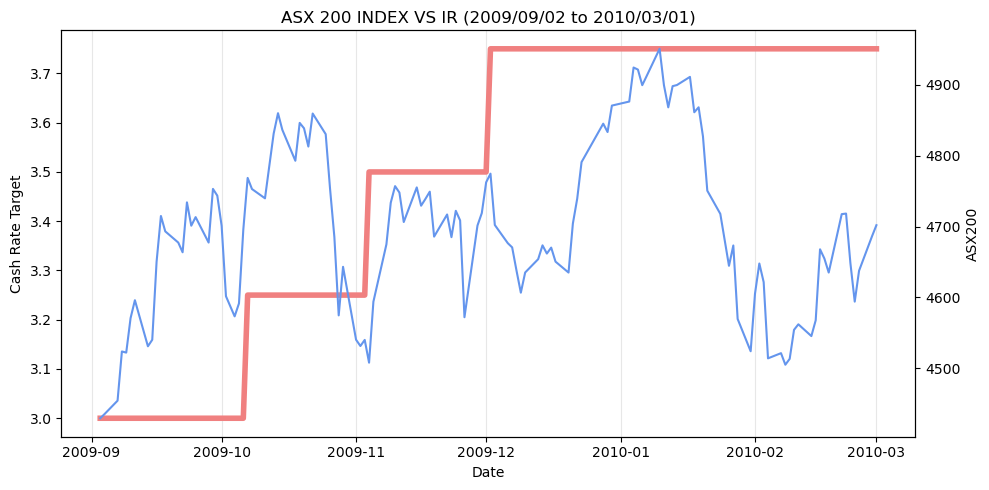

In [68]:
# Defien a function to plot similar charts
def plot_peaks(df_IR,df_peak,i):
    
    #Start Date and End date
    end_date = pd.to_datetime(enddt_lst.values[i])
    end_date = end_date.strftime('%Y/%m/%d')
   
    start_date = pd.to_datetime(startdt_lst.values[i])
    start_date = start_date.strftime('%Y/%m/%d')

    plt.style.use('default')

    fig, ax1 = plt.subplots()

    ax1.plot(df_IR, color = 'lightcoral', lw=4)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cash Rate Target')
    ax1.tick_params(axis='y')
    ax1.grid(axis='x', alpha=0.3)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.plot(df_peak['Close'], color ='cornflowerblue')
    ax2.set_ylabel('ASX200')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y')
    # ax2.set_ylim([2500, 7500])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.set_size_inches(10,5)
    plt.title(f"ASX 200 INDEX VS IR ({start_date} to {end_date})")
    plt.tight_layout()
    #plt.subplots_adjust(top=0.88)

    plt.savefig(f"Chart {i}.png")

#Define Counter
i = 0

# Iterate through the peaks we have chosen, to get charts
for i in range(len(IR_peak_lst)):
    plot_peaks(IR_peak_lst[i],ASX_peak_lst[i],i)
    i += 1
